In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.preprocessing import LabelEncoder

import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = '/kaggle/input/visual-taxonomy/train_images'
test_dir = '/kaggle/input/visual-taxonomy/test_images'
train_csv = '/kaggle/input/visual-taxonomy/train.csv'
test_csv = '/kaggle/input/visual-taxonomy/test.csv'
sample_submission = '/kaggle/input/visual-taxonomy/sample_submission.csv'
cat_attr = '/kaggle/input/visual-taxonomy/category_attributes.parquet'

In [5]:
model_category = 'Kurtis'

In [6]:
train_df = pd.read_csv(train_csv)
train_df

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,NaN,NaN,NaN,NaN,NaN
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70208,70374,Women Tops & Tunics,10,multicolor,fitted,regular,square neck,casual,printed,default,short sleeves,regular sleeves,ruffles
70209,70375,Women Tops & Tunics,10,yellow,regular,crop,round neck,casual,default,default,short sleeves,regular sleeves,knitted
70210,70376,Women Tops & Tunics,10,maroon,fitted,crop,round neck,casual,solid,solid,short sleeves,regular sleeves,knitted
70211,70377,Women Tops & Tunics,10,NaN,NaN,NaN,high,NaN,NaN,NaN,short sleeves,NaN,NaN


In [ ]:
train_df_cat = train_df[train_df['Category'] == model_category]
n = 10 - (train_df_cat['len'].values[0])
if (n != 0):
    train_df_cat.drop(columns=train_df_cat.columns[-n:], axis=1, inplace=True)
# train_df_cat.drop(["attr_6","attr_7","attr_8","attr_9","attr_10"], axis =1, inplace = True)
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
25613,25778,Kurtis,9,black,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular
25614,25779,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25615,25780,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25616,25781,Kurtis,9,navy blue,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25617,25782,Kurtis,9,black,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
...,...,...,...,...,...,...,...,...,...,...,...,...
32430,32596,Kurtis,9,black,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32431,32597,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32432,32598,Kurtis,9,multicolor,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32433,32599,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular


In [8]:
cat_attr_df = pd.read_parquet(cat_attr)
pd.set_option('display.max_colwidth', None)
cat_attr_df

,Category,No_of_attribute,Attribute_list
0,Men Tshirts,5,"[color, neck, pattern, print_or_pattern_type, sleeve_length]"
1,Sarees,10,"[blouse_pattern, border, border_width, color, occasion, ornamentation, pallu_details, pattern, print_or_pattern_type, transparency]"
2,Kurtis,9,"[color, fit_shape, length, occasion, ornamentation, pattern, print_or_pattern_type, sleeve_length, sleeve_styling]"
3,Women Tshirts,8,"[color, fit_shape, length, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"
4,Women Tops & Tunics,10,"[color, fit_shape, length, neck_collar, ocassion, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"


In [ ]:
# Step 1: Extract the attribute list for "Men Tshirts" from cat_attr_df
men_tshirts_attributes = cat_attr_df.loc[cat_attr_df['Category'] == model_category, 'Attribute_list'].values[0]

# Step 2: Create a mapping for the columns
# Assuming attr_1 corresponds to the first item in Attribute_list, attr_2 to the second, etc.
attr_columns = train_df_cat.filter(like='attr_').columns.to_list() # Adjust if more attributes exist
print(attr_columns)
rename_dict = {f'attr_{i+1}': men_tshirts_attributes[i] for i in range(len(attr_columns))}

# Step 3: Rename the columns in Men_Tshirts_df
# train_df_cat.rename(columns=rename_dict, inplace=True)

# Now you can print or check the updated DataFrame
train_df_cat

['attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_8', 'attr_9']


,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
25613,25778,Kurtis,9,black,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular
25614,25779,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25615,25780,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25616,25781,Kurtis,9,navy blue,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
25617,25782,Kurtis,9,black,straight,knee length,daily,default,default,default,three-quarter sleeves,regular
...,...,...,...,...,...,...,...,...,...,...,...,...
32430,32596,Kurtis,9,black,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32431,32597,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32432,32598,Kurtis,9,multicolor,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular
32433,32599,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular


In [ ]:
def format_image_path(row):
    return f"/kaggle/input/visual-taxonomy/train_images/{str(row['id']).zfill(6)}.jpg"

# Add the new column 'image_path' using the formatted id
train_df_cat['image_path'] = train_df_cat.apply(format_image_path, axis=1)
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,image_path
25613,25778,Kurtis,9,black,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025778.jpg
25614,25779,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025779.jpg
25615,25780,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025780.jpg
25616,25781,Kurtis,9,navy blue,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025781.jpg
25617,25782,Kurtis,9,black,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025782.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32430,32596,Kurtis,9,black,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032596.jpg
32431,32597,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032597.jpg
32432,32598,Kurtis,9,multicolor,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032598.jpg
32433,32599,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032599.jpg


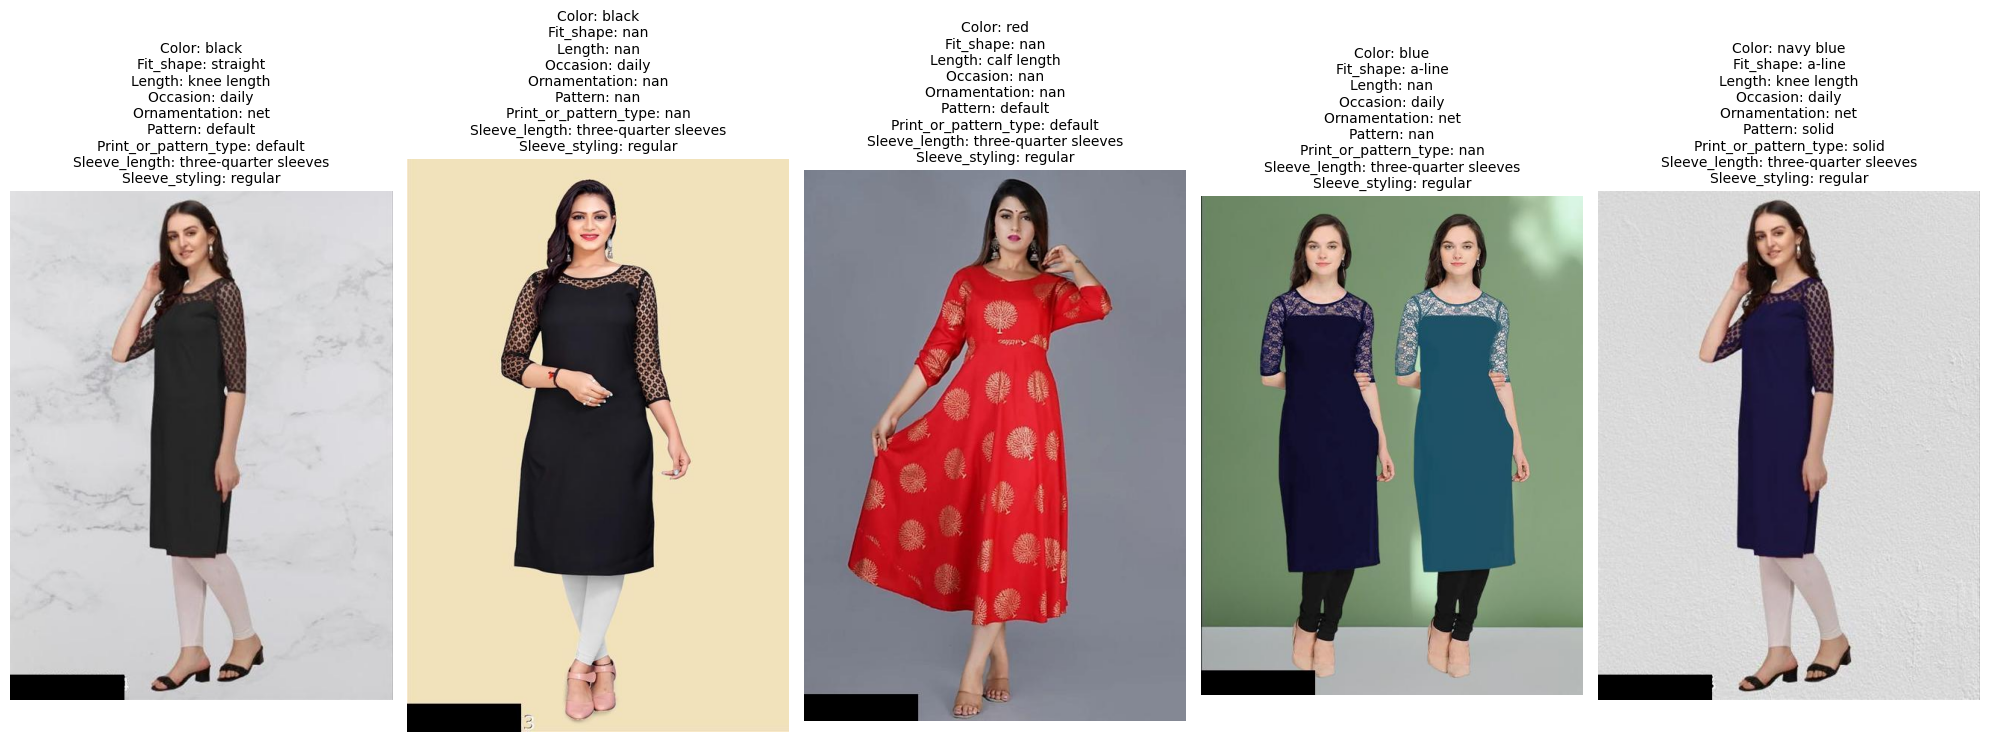

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

# Sample 5 random images from the DataFrame
sample_df = train_df_cat.sample(5)

# Create subplots to display the images with their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  # 5 images, side by side

# Loop through each image and label
for i, (idx, row) in enumerate(sample_df.iterrows()):
    # Read the image
    img = mpimg.imread(row['image_path'])
    
    # Display the image in the subplot
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis for a cleaner look
    
    # Set the title with the labels
    label = ""
    for attr, renamed_key in rename_dict.items():
        label += f"{renamed_key.capitalize()}: {row[attr]}\n"

    # Remove the last newline character
    label = label.strip()
    axes[i].set_title(label, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Get value counts for each specified column
columns_of_interest = attr_columns

for column in columns_of_interest:
    print(f"Value counts for {column}:\n")
    print(train_df_cat[column].value_counts(dropna=False))  # Including NaN values
    print("\n" + "-"*50 + "\n")

Value counts for attr_1:

attr_1
black         1395
red           1376
maroon        1071
navy blue      717
blue           426
multicolor     407
yellow         353
green          258
pink           220
NaN            193
purple         170
grey           137
white           66
orange          33
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_2:

attr_2
NaN         3591
a-line      2066
straight    1165
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_3:

attr_3
NaN            3422
knee length    2048
calf length    1352
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_4:

attr_4
daily    5961
party     470
NaN       391
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_5:

attr_5
NaN        3556
net        2287
default     979
Name: count, dtype: int64

-------------------------

In [13]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torchvision import models, transforms
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply Color Jitter
    transforms.RandomHorizontalFlip(),  # Apply Horizontal Flip with 50% probability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# for attribute in [f'attr_{j+1}' for j in range(10)]:
#     le = LabelEncoder()
#     train_df_cat[attribute] = le.fit_transform(train_df_cat[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding
# #     label_encoders[attribute] = le

In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,image_path
25613,25778,Kurtis,9,black,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025778.jpg
25614,25779,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025779.jpg
25615,25780,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025780.jpg
25616,25781,Kurtis,9,navy blue,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025781.jpg
25617,25782,Kurtis,9,black,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025782.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32430,32596,Kurtis,9,black,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032596.jpg
32431,32597,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032597.jpg
32432,32598,Kurtis,9,multicolor,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032598.jpg
32433,32599,Kurtis,9,red,NaN,NaN,daily,NaN,NaN,NaN,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032599.jpg


In [17]:
class ShirtDataset(Dataset):
    def __init__(self, dataframe, attribute, transform=None):
        self.dataframe = dataframe
        self.attribute = attribute
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        # Get attribute label (NaN values handled by replacing with -1)
        label = row[self.attribute] if not pd.isna(row[self.attribute]) else -1
        return img, label

# Function to train DenseNet for a specific attribute
def train_densenet(df, attribute):
    # Filter rows with non-NaN values for training
    train_df = df[df[attribute].notna()].copy()  # Use only rows with valid labels
#     for attribute in [f'attr_{j+1}' for j in range(10)]:
    le = LabelEncoder()
    train_df[attribute] = le.fit_transform(train_df[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding
#     label_encoders[attribute] = le
    

    # Define dataset and dataloader
    train_dataset = ShirtDataset(train_df, attribute, transform=preprocess)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Load a pre-trained DenseNet model and adjust final layer
    densenet = models.efficientnet_b5(pretrained=True)
    num_features = 2048
    densenet.classifier = nn.Linear(num_features, len(train_df[attribute].unique()))
    densenet = densenet.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(densenet.parameters(), lr=0.0001)

    # Training loop
    densenet.train()
    for epoch in range(4):  # Use more epochs as needed
        for images, labels in tqdm(train_loader, desc=f"Training {attribute}"):
            images = images.to(device)
            labels = labels.to(device).long()
            
            # Forward pass
            outputs = densenet(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Set model to evaluation mode
    densenet.eval()
    return densenet,le

# Function to impute missing values using the trained DenseNet
def impute_attribute(df, attribute, model,le):
    # Dataset and loader for missing values
    nan_df = df[df[attribute].isna()].copy()  # Select rows with NaN in the attribute
    nan_dataset = ShirtDataset(nan_df, attribute, transform=preprocess)
    nan_loader = DataLoader(nan_dataset, batch_size=32, shuffle=False)

    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(nan_loader, desc=f"Predicting {attribute}"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            predictions_ = le.inverse_transform(np.array(predictions))

    # Fill NaNs with predictions
    df.loc[df[attribute].isna(), attribute] = predictions_
    print(df.info())
    return df

In [ ]:
from tqdm import tqdm

for j in tqdm(range(9)):
    model,le = train_densenet(train_df_cat,f'attr_{j+1}')
    train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}',model,le)

  0%|          | 0/9 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth

  0%|          | 0.00/117M [00:00<?, ?B/s]
 10%|▉         | 11.1M/117M [00:00<00:00, 116MB/s]
 24%|██▍       | 27.9M/117M [00:00<00:00, 151MB/s]
 40%|███▉      | 46.2M/117M [00:00<00:00, 169MB/s]
 56%|█████▌    | 65.6M/117M [00:00<00:00, 183MB/s]
 74%|███████▍  | 86.2M/117M [00:00<00:00, 194MB/s]
100%|██████████| 117M/117M [00:00<00:00, 191MB/s]

Training attr_1: 100%|██████████| 208/208 [02:57<00:00,  1.17it/s]

Training attr_1: 100%|██████████| 208/208 [02:36<00:00,  1.33it/s]

Training attr_1: 100%|██████████| 208/208 [02:35<00:00,  1.34it/s]

Training attr_1: 100%|██████████| 208/208 [02:35<00:00,  1.34it/s]

 11%|█         | 1/9 [10:50<1:26:45, 650.69s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      3231 non-null   object
 5   attr_3      3400 non-null   object
 6   attr_4      6431 non-null   object
 7   attr_5      3266 non-null   object
 8   attr_6      3848 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_2: 100%|██████████| 101/101 [01:15<00:00,  1.33it/s]

Training attr_2: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s]

Training attr_2: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s]

Training attr_2: 100%|██████████| 101/101 [01:15<00:00,  1.33it/s]

 22%|██▏       | 2/9 [17:04<56:53, 487.68s/it]  

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      3400 non-null   object
 6   attr_4      6431 non-null   object
 7   attr_5      3266 non-null   object
 8   attr_6      3848 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_3: 100%|██████████| 107/107 [01:20<00:00,  1.32it/s]

Training attr_3: 100%|██████████| 107/107 [01:20<00:00,  1.34it/s]

Training attr_3: 100%|██████████| 107/107 [01:19<00:00,  1.34it/s]

Training attr_3: 100%|██████████| 107/107 [01:19<00:00,  1.34it/s]

 33%|███▎      | 3/9 [23:32<44:13, 442.17s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6431 non-null   object
 7   attr_5      3266 non-null   object
 8   attr_6      3848 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_4: 100%|██████████| 201/201 [02:31<00:00,  1.33it/s]

Training attr_4: 100%|██████████| 201/201 [02:30<00:00,  1.33it/s]

Training attr_4: 100%|██████████| 201/201 [02:30<00:00,  1.33it/s]

Training attr_4: 100%|██████████| 201/201 [02:30<00:00,  1.34it/s]

 44%|████▍     | 4/9 [33:43<42:24, 509.00s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      3266 non-null   object
 8   attr_6      3848 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_5: 100%|██████████| 103/103 [01:17<00:00,  1.33it/s]

Training attr_5: 100%|██████████| 103/103 [01:16<00:00,  1.34it/s]

Training attr_5: 100%|██████████| 103/103 [01:16<00:00,  1.35it/s]

Training attr_5: 100%|██████████| 103/103 [01:16<00:00,  1.34it/s]

 56%|█████▌    | 5/9 [40:01<30:46, 461.55s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      6822 non-null   object
 8   attr_6      3848 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_6: 100%|██████████| 121/121 [01:30<00:00,  1.33it/s]

Training attr_6: 100%|██████████| 121/121 [01:29<00:00,  1.34it/s]

Training attr_6: 100%|██████████| 121/121 [01:29<00:00,  1.35it/s]

Training attr_6: 100%|██████████| 121/121 [01:30<00:00,  1.33it/s]

 67%|██████▋   | 6/9 [47:00<22:21, 447.10s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      6822 non-null   object
 8   attr_6      6822 non-null   object
 9   attr_7      3843 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_7: 100%|██████████| 121/121 [01:31<00:00,  1.32it/s]

Training attr_7: 100%|██████████| 121/121 [01:30<00:00,  1.34it/s]

Training attr_7: 100%|██████████| 121/121 [01:30<00:00,  1.34it/s]

Training attr_7: 100%|██████████| 121/121 [01:30<00:00,  1.34it/s]

 78%|███████▊  | 7/9 [54:02<14:37, 438.87s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      6822 non-null   object
 8   attr_6      6822 non-null   object
 9   attr_7      6822 non-null   object
 10  attr_8      6702 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_8: 100%|██████████| 210/210 [02:38<00:00,  1.33it/s]

Training attr_8: 100%|██████████| 210/210 [02:36<00:00,  1.34it/s]

Training attr_8: 100%|██████████| 210/210 [02:37<00:00,  1.34it/s]

Training attr_8: 100%|██████████| 210/210 [02:37<00:00,  1.33it/s]

 89%|████████▉ | 8/9 [1:04:35<08:20, 500.65s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      6822 non-null   object
 8   attr_6      6822 non-null   object
 9   attr_7      6822 non-null   object
 10  attr_8      6822 non-null   object
 11  attr_9      6691 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None



Training attr_9: 100%|██████████| 210/210 [02:37<00:00,  1.33it/s]

Training attr_9: 100%|██████████| 210/210 [02:37<00:00,  1.33it/s]

Training attr_9: 100%|██████████| 210/210 [02:37<00:00,  1.33it/s]

Training attr_9: 100%|██████████| 210/210 [02:37<00:00,  1.34it/s]

100%|██████████| 9/9 [1:15:08<00:00, 500.95s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 6822 entries, 25613 to 32434
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6822 non-null   int64 
 1   Category    6822 non-null   object
 2   len         6822 non-null   int64 
 3   attr_1      6822 non-null   object
 4   attr_2      6822 non-null   object
 5   attr_3      6822 non-null   object
 6   attr_4      6822 non-null   object
 7   attr_5      6822 non-null   object
 8   attr_6      6822 non-null   object
 9   attr_7      6822 non-null   object
 10  attr_8      6822 non-null   object
 11  attr_9      6822 non-null   object
 12  image_path  6822 non-null   object
dtypes: int64(2), object(11)
memory usage: 746.2+ KB
None


In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,image_path
25613,25778,Kurtis,9,black,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025778.jpg
25614,25779,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025779.jpg
25615,25780,Kurtis,9,red,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025780.jpg
25616,25781,Kurtis,9,navy blue,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025781.jpg
25617,25782,Kurtis,9,black,straight,knee length,daily,default,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/025782.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32430,32596,Kurtis,9,black,straight,knee length,daily,net,default,default,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032596.jpg
32431,32597,Kurtis,9,red,a-line,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032597.jpg
32432,32598,Kurtis,9,multicolor,a-line,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032598.jpg
32433,32599,Kurtis,9,red,straight,knee length,daily,net,solid,solid,three-quarter sleeves,regular,/kaggle/input/visual-taxonomy/train_images/032599.jpg


In [ ]:
train_df_cat['attr_1'].isnull().sum()

0

In [ ]:
train_df_cat.to_csv('output/train_fillna_Kurtis_effnet_b5_4epochs.csv',index=False)

In [ ]:
# from tqdm import tqdm

# for j in tqdm(range(10)):
#     train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}')